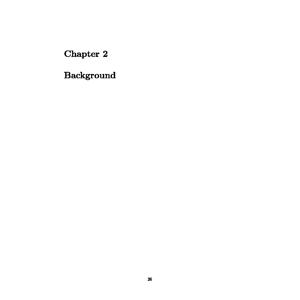

In [2]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from time import time
original_image = Image.open("chapter_2.png")

def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

original_image = expand2square(original_image, (255,255,255))

im = original_image.convert("L").resize((300, 300))
im

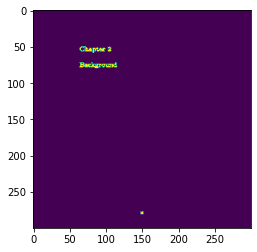

In [3]:
src = np.array(im) < 200
plt.imshow(src)

CPU times: user 347 ms, sys: 65.1 ms, total: 412 ms
Wall time: 361 ms


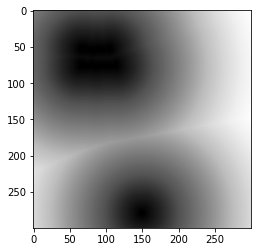

In [4]:
%%time
pixels = np.array(np.where(src))[:, :]

I = np.arange(src.shape[0]).reshape(-1,1,1)
J = np.arange(src.shape[1]).reshape(1,-1,1)

groups = 50

def compute(k):
    i, j = pixels[:, k::groups].reshape(2, 1, 1, -1)
    dist = np.min(np.sqrt((I - i)**2 + (J - j)**2), axis = -1, initial = 1000)
    return dist

dist = np.min([compute(k) for k in range(groups)], axis = 0)

d =  1 - dist / np.max(dist)
plt.imshow(d, cmap = 'Greys')

0.00012339457598623172 0.7310585786300048


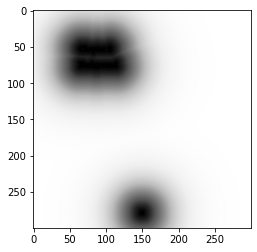

In [5]:
a = 10 # how hard the falloff with distance is, larger means harder edge
b = 0.9 #density between 0 and 1
def l(x): return a*(x - b)
def s(x): return  np.exp(x) / (1 +  np.exp(x))

def smoothstep(x, falloff, midpoint, minimum, maximum):
    """
    A smooth step function
    transitions from s(x) = minimum when x << midpoint
    to s(x) = maximum when x >> midpoint
    with cutoff controlled by falloff, larger tends towards a step function
    """
    y = falloff*(x - midpoint)
    output_range = maximum - minimum
    z = np.exp(y) / (1 +  np.exp(y))
    return minimum + output_range * z

# mask = s(l(d))
mask = smoothstep(d, falloff = 10, midpoint = 0.9, minimum = 0, maximum = 1)
print(np.min(mask), np.max(mask))
plt.imshow(mask, cmap = 'Greys')

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

@jit(nopython=True, nogil=True)
def energy_difference_mag_field(state, magnetic_field, site):
    # loop over the four neighbours of the site, skipping if the site is near an edge
    N, M = state.shape
    i, j = site
    h = 0
    for di, dj in [[-1, 0], [1, 0], [0, -1], [0, 1]]:  # loop over N,E,S,W neighbours
        if (0 <= (i + di) < N) and (
            0 <= (j + dj) < M
        ):  # ignore neighbours not in the NxN grid
            h += state[i + di, j + dj]
    return 4 * state[i, j] * (h + magnetic_field[i, j]) 

@jit(nopython=True, nogil=True)
def mcmc_generator(
    initial_state, magnetic_field, steps, T, stepsize=1000
):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    for _ in range(steps):
        for _ in range(stepsize):
            i, j = np.random.randint(N), np.random.randint(N)

            # calculate the energy change if we were to flip this pixel but don't actually do it
            change_in_E = energy_difference_mag_field(current_state, magnetic_field, (i, j))

            if change_in_E < 0 or np.exp(-change_in_E / T) > np.random.random():
                current_state[i, j] *= -1  # accept the change!

        yield current_state.copy()
    return

@jit(nopython=True, nogil=True)
def mcmc_generator_variable_T(
    initial_state, magnetic_field, steps, T, stepsize=1000
):
    N, M = initial_state.shape
    assert N == M

    current_state = initial_state.copy()
    for _ in range(steps):
        for _ in range(stepsize):
            i, j = np.random.randint(N), np.random.randint(N)

            # calculate the energy change if we were to flip this pixel but don't actually do it
            change_in_E = energy_difference_mag_field(current_state, magnetic_field, (i, j))

            if change_in_E < 0 or np.exp(-change_in_E / T[i, j]) > np.random.random():
                current_state[i, j] *= -1  # accept the change!

        yield current_state.copy()
    return

-inf 0.0


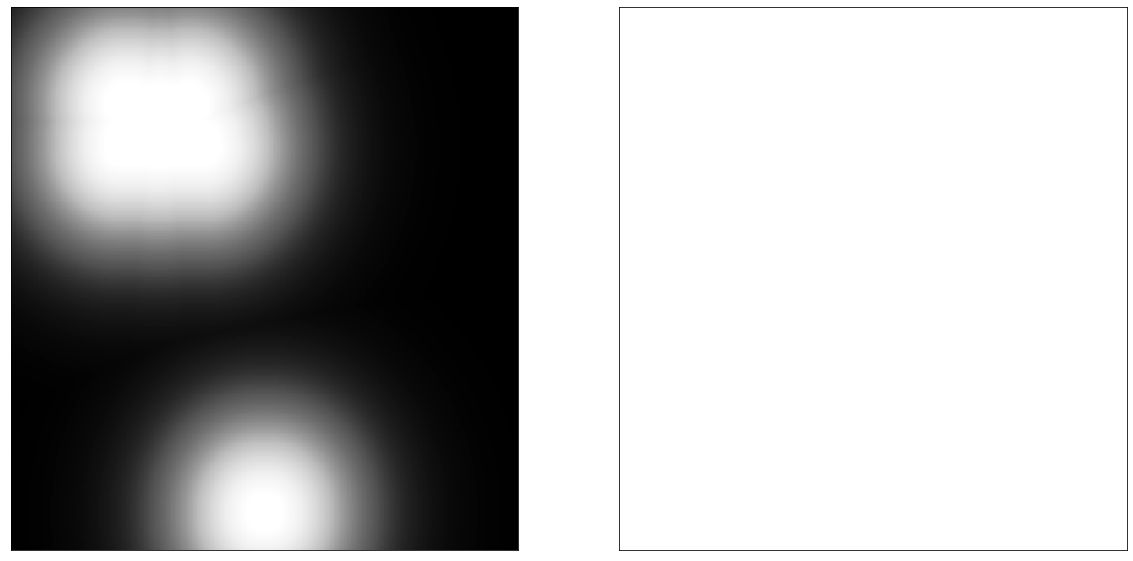

In [7]:
a = 10 # how hard the falloff with distance is, larger means harder edge
b = 0.9 #density between 0 and 1
def l(x): return a*(x - b)
def s(x): return  np.exp(x) / (1 +  np.exp(x))

mask = s(l(d[::-1, :]))

l, h = np.min(mask), np.max(mask)
m = (l+h) / 2
magnetic_field = -(mask - l) / h * 0.5

mask = magnetic_field < -0.44
magnetic_field = 1 - 1 / (-0.44 + magnetic_field)
magnetic_field[mask] = -np.inf

magnetic_field = magnetic_field - np.max(magnetic_field)

print(np.min(magnetic_field), np.max(magnetic_field))
magnetic_field = magnetic_field.repeat(4, axis=0).repeat(4, axis=1)

f, axes = plt.subplots(ncols = 2, figsize = (20,10))
axes[0].pcolormesh(magnetic_field, cmap="Greys")
# axes[1].matshow(state, cmap="Greys", vmin=-1, vmax=1)
for ax in axes: ax.set(xticks=[], yticks=[])

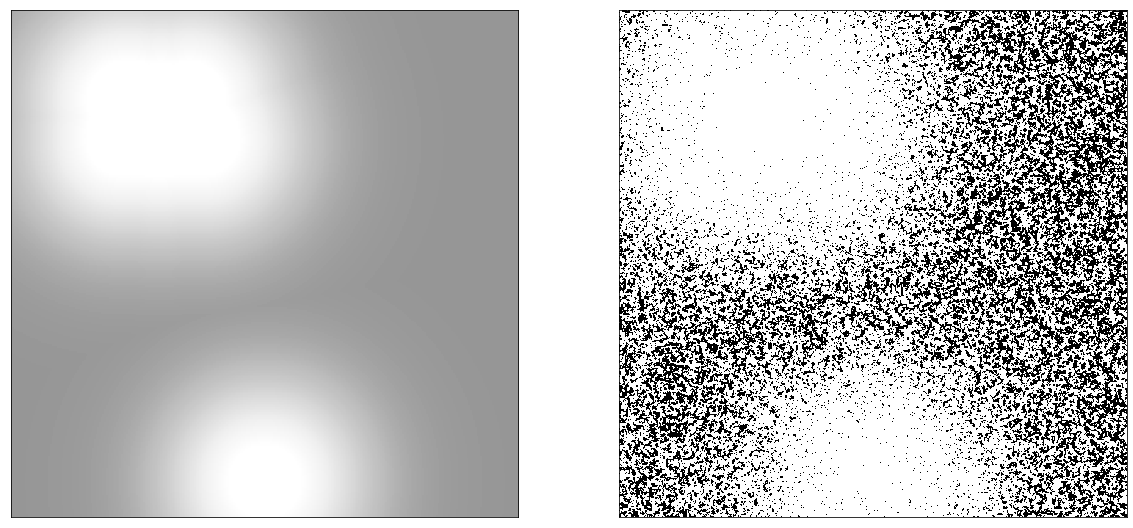

In [151]:
### Simulation Inputs ###
steps = 1  # How many times to sample the state
stepsize = (
    10 * N**2
)  # How many individual monte carlo flips to do in between each sample
T = 3.5

initial_state = np.random.choice(np.array([-1, 1], dtype=np.int8), size=magnetic_field.shape)  # the intial state to use


### Simulation Code ###
state = next(mcmc_generator(initial_state, magnetic_field, steps=steps, stepsize=stepsize, T=T))


f, axes = plt.subplots(ncols = 2, figsize = (20,10))
axes[0].matshow(magnetic_field, cmap="Greys", vmin=-1, vmax=1)
axes[1].matshow(state, cmap="Greys", vmin=-1, vmax=1)
for ax in axes: ax.set(xticks=[], yticks=[])


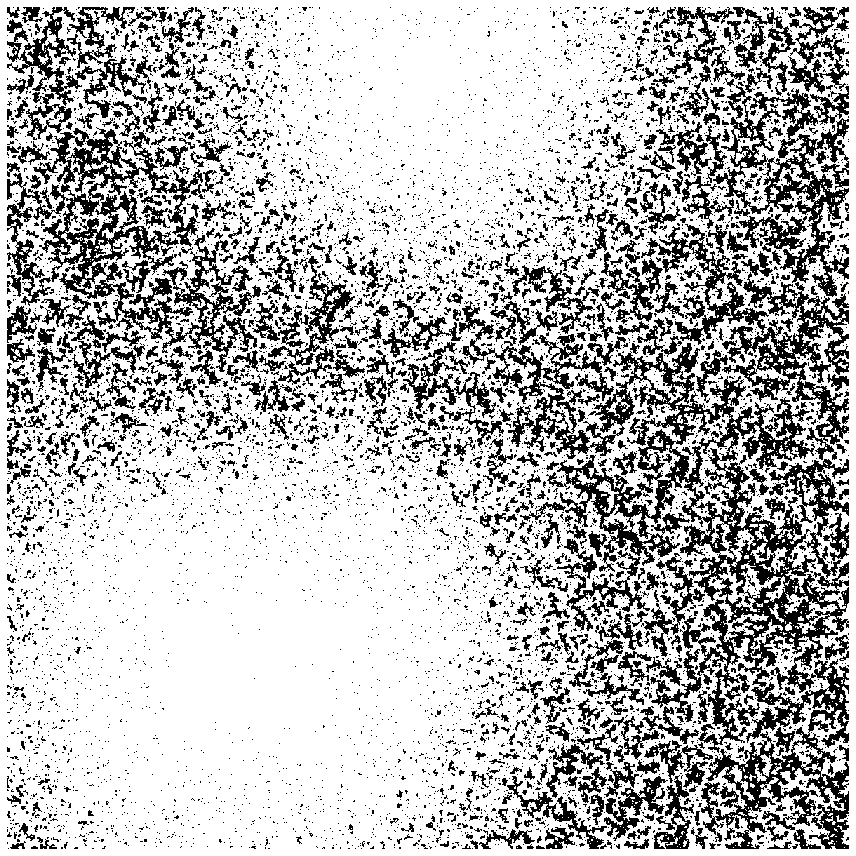

In [152]:
w,h = (11.6929, 11.6929)
fig = plt.figure(frameon=False)
fig.set_size_inches(w,h)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.pcolor(state, cmap="Greys", vmin=-1, vmax=1, shading = "flat")
fig.savefig("ising.png")

0.3875234316421068 4.936697715605043


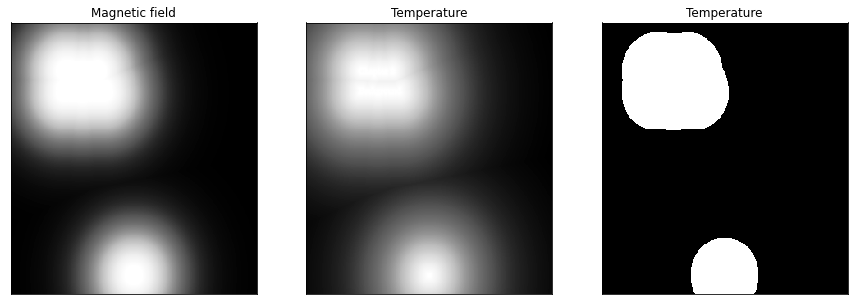

In [11]:
# magnetic_field = 0.0 * np.ones_like(d)
temperature = 3.5 * np.ones_like(d)
temperature = smoothstep(d[::-1, :], falloff = 5, midpoint = 0.99, minimum = 5, maximum = -4)
print(np.min(temperature), np.max(temperature))

f, axes = plt.subplots(ncols = 3, figsize = (15,5))

axes[0].set(title = "Magnetic field")
axes[0].pcolormesh(magnetic_field, cmap="Greys")

axes[1].set(title = "Temperature")
axes[1].pcolormesh(temperature, cmap="Greys")

axes[2].set(title = "Temperature")
axes[2].pcolormesh(d[::-1, :] < 0.8, cmap="Greys")

# axes[1].matshow(state, cmap="Greys", vmin=-1, vmax=1)
for ax in axes: ax.set(xticks=[], yticks=[])

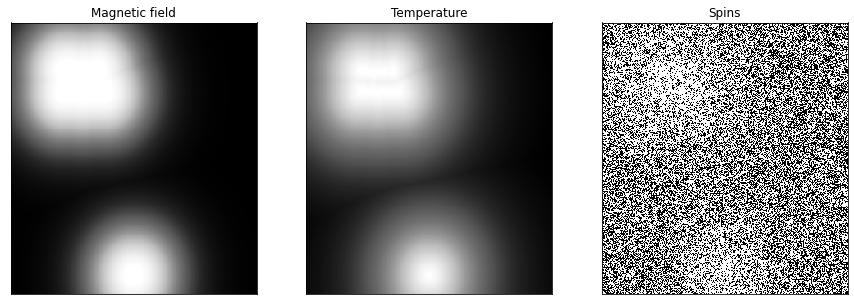

In [13]:
### Simulation Inputs ###
upsample = 4
magnetic_field_up = magnetic_field # reuse the magnetic field from the previous calculation
# magnetic_field_up = magnetic_field.repeat(upsample, axis=0).repeat(upsample, axis=1)
temperature_up = temperature.repeat(upsample, axis=0).repeat(upsample, axis=1)
d_up = d[::-1, :].repeat(upsample, axis=0).repeat(upsample, axis=1)

initial_state = np.random.choice(np.array([-1, 1], dtype=np.int8), size=magnetic_field_up.shape)  # the intial state to use
# initial_state = -np.ones(dtype=np.int8, shape=magnetic_field.shape)  # the intial state to use
# initial_state[d_up > 0.8] = -1

steps = 1  # How many times to sample the state
N = initial_state.shape[0]
stepsize = (
  1 * N**2
)  # How many individual monte carlo flips to do in between each sample



### Simulation Code ###
state = next(mcmc_generator_variable_T(initial_state,
                                       magnetic_field_up,
                                       steps=steps, stepsize=stepsize, 
                                       T= temperature_up))


f, axes = plt.subplots(ncols = 3, figsize = (15,5))

axes[0].set(title = "Magnetic field")
axes[0].pcolormesh(magnetic_field, cmap="Greys")

axes[1].set(title = "Temperature")
axes[1].pcolormesh(temperature, cmap="Greys")

axes[2].set(title = "Spins")
axes[2].pcolormesh(state, cmap="Greys")


for ax in axes: ax.set(xticks=[], yticks=[])
